In [118]:
import sys
sys.path.append('../bayesopt')

import read_agg_data
import torch
import torch.nn as nn
import torch.autograd as auto
import torch.optim as optim

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

import pdb
import math

dvfs_dict = {
    "0xc00" :  1.2,
    "0xd00" :  1.3,
    "0xe00" :  1.4,
    "0xf00" :  1.5,
    "0x1000" : 1.6,
    "0x1100" : 1.7,
    "0x1200" : 1.8,
    "0x1300" : 1.9,
    "0x1400" : 2.0,
    "0x1500" : 2.1,
    "0x1600" : 2.2,
    "0x1700" : 2.3,
    "0x1800" : 2.4,
    "0x1900" : 2.5,
    "0x1a00" : 2.6,
    "0x1b00" : 2.7,
    "0x1c00" : 2.8,
    "0x1d00" : 2.9,
    "0xffff" : 3.0,
}

In [119]:
#df_comb, _, _ = read_agg_data.start_analysis('mcd') #DATA
#df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: int(x, base=16))

df_comb = pd.read_csv('/home/handong/jupyter/jupyter-notebooks/nic-tuning-experiments/bayesopt/summary_data/node_combined.csv', sep=' ')
df_comb['msg'] = 148
df_comb = df_comb[(df_comb['i'] == 1) & (df_comb['rapl'] == 135)]
#df_comb = df_comb[(df_comb['rapl'] == 135)]

df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: dvfs_dict[x])
df_comb = df_comb[(df_comb['itr']!=1) & (df_comb['dvfs']!=65535)] #filter out linux dynamic

print(df_comb['time'].min())
print(df_comb.columns)
print(df_comb['msg'].min())
print(df_comb['itr'].unique())
print(df_comb['dvfs'].unique())
print(df_comb['sys'].unique())
print(df_comb.shape[0])

# df_comb['dvfs'] = df_comb['dvfs'].astype(float) / df_comb['dvfs'].min()
# print(df_comb['dvfs'].unique())
# df_comb['itr'] = df_comb['itr'].astype(float) / df_comb['itr'].min()
# print(df_comb['itr'].unique())
#print(10**6)

5.5998
Index(['sys', 'i', 'itr', 'dvfs', 'rapl', 'lat50', 'lat75', 'lat90', 'lat99',
       'requests', 'time', 'joules', 'rx_desc', 'rx_bytes', 'tx_desc',
       'tx_bytes', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'c1',
       'c1e', 'c3', 'c6', 'c7', 'num_interrupts', 'msg'],
      dtype='object')
148
[ 0  2  4  6  8 12 16 20 24 28 32 36 40 80 50 60 70]
[2.9 2.7 2.5 2.1 1.3 2.3 1.9 1.7 1.5]
['ebbrt_tuned' 'linux_tuned']
284


In [120]:
#6  8 10 12 16 20 24 28
for itr in [6, 8, 10, 12, 16, 20, 24, 28]:
    for sys in ['ebbrt_tuned']:
        df = df_comb[(df_comb['sys']==sys)].copy()
        #print(df.shape[0])
        print(df['joules'].max())
        #df['joules_per_interrupt'] = df['joules']/df['num_interrupts']
        df = df[['joules','itr', 'dvfs', 'time', 'num_interrupts', 'msg']]
        #print(df.shape[0])
        #print('')

        dfi = df[df['itr']==itr]
        #dfi = dfi.drop_duplicates(subset = ["itr", "dvfs"])
        #dfi['joules_mean'] = dfi['joules_mean']/dfi['joules_mean'].max()
        #print(dfi.diff())
        print('*******', sys, itr, msg)
        print(dfi.sort_values(by=['dvfs']))
        #print(dfi.sort_values(by=['dvfs']).diff())
        print('')
        #plt.plot(dfi['dvfs'], dfi['joules_per_interrupt'])
        #print(dfi)

425.38
******* ebbrt_tuned 6 8192
    joules  itr  dvfs    time  num_interrupts  msg
93  188.94    6   1.3  9.7990            1712  148
90  174.40    6   1.5  8.4992            5823  148
87  185.23    6   1.7  8.4995          109308  148
84  200.15    6   1.9  8.5994          177416  148
81  207.64    6   2.1  8.3997          196605  148
78  176.84    6   2.3  6.7997          199814  148
75  193.73    6   2.5  7.0996          195838  148
72  210.69    6   2.7  7.2999          190382  148
70  239.24    6   2.9  7.9001          175002  148

425.38
******* ebbrt_tuned 8 8192
     joules  itr  dvfs     time  num_interrupts  msg
117  194.78    8   1.3  10.1000            1646  148
112  180.96    8   1.7   8.2999           86818  148
109  202.30    8   1.9   8.7001          173028  148
104  179.90    8   2.3   6.8989          200344  148
101  198.81    8   2.5   7.2995          195309  148
98   218.95    8   2.7   7.5995          189618  148
96   247.14    8   2.9   8.1996          169298  1

In [12]:
print(8192*8/(10**10))

6.5536e-06


In [102]:
def inference(d, n_iter, lr, workload, sys, print_freq=10):
    # p_busy_min = 20
    p_static = {
        'c1':1.5, 
        'c3':0.5,
        'c4':0.25,
        'c7':34, # 34 Watts
        'busy': 10
    }
    chosen_sleep = 'c7'

    p_q = p_static[chosen_sleep]/10**6 # joules/us idle
    # p_detect = p_static[chosen_sleep]

    #<ipython-input-38-bca31b34de20>:16: UserWarning: To copy construct from a tensor, 
    # it is recommended to use sourceTensor.clone().detach() 
    # or sourceTensor.clone().detach().requires_grad_(True), 
    # rather than torch.tensor(sourceTensor).
    
    #starts randomly
    max_time = torch.tensor(torch.Tensor(1,1).uniform_(1, 2), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 0), requires_grad=True)
    beta = torch.tensor(torch.Tensor(1,1).uniform_(0, 1), requires_grad=True)
    gamma = torch.tensor(torch.Tensor(1,1).uniform_(0, 1), requires_grad=True)
    delta = torch.tensor(torch.Tensor(1,1).uniform_(2, 3), requires_grad=True)
    
    #beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2)).clone().detach()
    #p_static_busy = torch.tensor(torch.Tensor(1,1).uniform_(0, 35)).clone().detach()
    #p_detect = torch.tensor(torch.Tensor(1,1).uniform_(0, 35)).clone().detach()
    #p_q = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_busy_min = torch.tensor(torch.Tensor(1,1).uniform_(0, 35)).clone().detach()
    #itr_suppress = torch.rand(1, requires_grad=True)
    #itr_suppress = torch.tensor(1., requires_grad=True)
    
    #AA = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2)).clone().detach()
    #BB = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2)).clone().detach()
    #gamma = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1)).clone().detach()
    
    #df[['joules_mean','itr', 'dvfs', 'QPS', 'read_99th_mean']]
    #df[['joules', 'itr', 'dvfs', 'time', 'num_interrupts']]
    ninterrupts = d[:,4]
    energy = (d[:,0]/ninterrupts).log() ## joules/num_interrupts
    itr = d[:,1]
    dvfs = d[:,2]
    time = d[:,3]
    msgsize = d[:,5]
    
    #current_loss_time = -100
    #fixed_max_time = -100
    #fixed_alpha = -100
    #fixed_itr_suppress = -100
        
    criterion = nn.MSELoss()
    #optimizer_time = optim.Adam([max_time, alpha, gamma, delta], lr=lr)
    optimizer_time = optim.Adam([max_time, alpha, gamma, delta], lr=lr)
    #optimizer_energy = optim.Adam([gamma, beta], lr=lr)

    for i in range(n_iter):        
        t_busy = (torch.exp(max_time) / dvfs**(1+alpha)) ## dvfs impact on processing
        
        #pred_time = itr_suppress*itr + t_busy
        #pred_time = ((2*((itr*itr_suppress)**beta))/(10**6)) + (gamma*(2*((msgsize*8)/(10**10)))) + (2*t_busy)
        #pred_time = (gamma*itr*itr_suppress)*(dvfs**beta)
        #pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy)                
        
        #pred_time = (((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))*gamma)
        beta = gamma*dvfs+delta
        pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))
        
        #pred_time = A(itr)**beta*(dvfs**gamma)
        #pred_time = 2*itr**(alpha*dvfs)
        
        #import pdb
        #pdb.set_trace()
        
        #loss_time = criterion(pred_time/time, torch.ones((1,pred_time.shape[1])).double())
        loss_time = criterion(pred_time, time)
        
        if i % 1000 == 0:
            #print(f'MSE_loss_time={loss_time.item()} loss_time={round(math.sqrt(loss_time.item())*10**6, 5)} us')
            print(f'MSE_loss_time={loss_time.item()} max_time={max_time.item()} '+ 
                    f'alpha={alpha.item()} gamma={gamma.item()} delta={delta.item()}')
 #itr_suppress={itr_suppress.item()}
            
        optimizer_time.zero_grad()
        loss_time.backward()
        optimizer_time.step()

#         if(current_loss_time == -100):
#             current_loss_time = loss_time.item()
#         else:
#             if(current_loss_time >= loss_time.item()):
#                 current_loss_time = loss_time.item()
#                 fixed_max_time = max_time.item()
#                 fixed_alpha = alpha.item()
                #fixed_itr_suppress = itr_suppress.item()
            
#     for i in range(n_iter):
#         #p_busy = (p_q*dvfs**(2+beta))
#         #t_busy_energy = (max_time / dvfs**(1+beta))
#         #t_q_energy = itr#(fixed_itr_suppress*itr)
#         #t_q_energy = (interarrival_time - (fixed_itr_suppress*itr) - t_busy_energy)
        
#         #pred_energy = (p_q * t_q_energy) + (p_busy * t_busy_energy)
#         #pred_energy = AA*(fixed_itr_suppress*itr)**gamma + BB*dvfs**beta
#         #loss_energy = criterion(pred_energy/energy, torch.ones((1,pred_energy.shape[1])).double())
#         #pred_energy =  ((fixed_itr_suppress*itr*p_q)*((20*(10**6))/(fixed_itr_suppress*itr))) + (dvfs*beta)
#         #pred_energy = (gamma*(fixed_itr_suppress*itr))*(dvfs**beta) #+ (AA*(dvfs**beta))
        
#         pred_energy = gamma+(np.log(fixed_itr_suppress)+np.log(itr))+(beta*np.log(dvfs))
        
#         #pred_energy = (*itr + t_busy_energy)*p_q
#         loss_energy = criterion(pred_energy, energy)

#         if i % 1000 == 0:
#             print(f'loss_energy={loss_energy.item()} gamma={gamma.item()} beta={beta.item()}')
#             #print(pred_energy)
            
#         optimizer_energy.zero_grad()
#         loss_energy.backward(retain_graph=True)
#         optimizer_energy.step()
    pred_energy = None
    return pred_energy, pred_time

In [103]:
def run_energy(df_comb, n_iter=2000, lr=1, msys=['ebbrt_tuned'], mpred=['energy', 'time']):       
    for sys in msys:
        df = df_comb[(df_comb['sys']==sys)].copy()
        #df = df[['joules','itr', 'dvfs', 'QPS', 'read_99th', 'num_interrupts']]
        print(df['itr'].unique())
        df = df[['joules', 'itr', 'dvfs', 'time', 'num_interrupts', 'msg']]
        
        tnum = df.shape[0]
        d = df.values
        d = torch.tensor(d)
        print('SYS', sys)
        #pred_energy, max_time, alpha, beta, p_detect, p_q = inference_energy(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        pred_energy, pred_time = inference(d, n_iter, lr, 'nodejs', sys, print_freq=1000)
        
        #df[f'pre_energy lr={lr}'] = pred_energy.view(tnum, 1).detach().numpy()
        df[f'pre_time lr={lr}'] = pred_time.view(tnum, 1).detach().numpy()
                
        for pred_name in mpred:
            if pred_name == 'energy':
                pred = pred_energy
                yvalue = (d[:,0]/d[:,4]).log()
                #yvalue = d[:,0]
            else:
                pred = pred_time
                yvalue = d[:,3]

            fig, ax = plt.subplots()
            plt.title(f'pred:{pred_name} NODEJS sys={sys} lr={lr} \n ')
            #plt.title(f'pred:{pred_name} mcd sys={sys} lr={lr} tail={rtail} \n QPS={rqps} max_time={round(max_time,2)} \n alpha={round(alpha,2)} beta={round(beta.item(),2)} \n p_detect={round(p_detect.item(),2)}')
            plt.xlabel(u"predictions")
            plt.ylabel(f'{pred_name}')
            print('yvalue', yvalue.shape)
            
            tmax = yvalue.max().item()
            plt.plot(np.linspace(0, tmax, 10), np.linspace(0, tmax, 10))
            
            scatter = ax.scatter(pred.detach().numpy(), yvalue, marker = 'o', 
                                 s = d[:,1], c = d[:,2], alpha=0.3)
            #scatter = ax.scatter(pred.detach().numpy(), yvalue, marker = 'o', alpha=0.3)
            plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
            
            
            legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="dvfs")
            ax.add_artist(legend1)
            handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
            legend2 = plt.legend(handles, labels, loc="lower right", title="itr")
            ax.add_artist(legend2)

[ 2  4  6  8 12 16 20 24 28 32 36 40 50 60 70 80  0]
SYS linux_tuned
MSE_loss_time=16934.131648371065 max_time=1.7223296165466309 alpha=-0.8468027710914612 gamma=0.7089595794677734 delta=2.5453941822052


<ipython-input-102-3ace74c5a2be>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(1, 2), requires_grad=True)
<ipython-input-102-3ace74c5a2be>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 0), requires_grad=True)
<ipython-input-102-3ace74c5a2be>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(0, 1), requires_grad=True)
<ipython-input-102-3ace74c5a2be>:24: UserWarning: To copy construct

MSE_loss_time=3.6468175795986975 max_time=2.436983108520508 alpha=-0.05861497297883034 gamma=0.4673231542110443 delta=2.3069944381713867
MSE_loss_time=3.208974976795988 max_time=2.419663190841675 alpha=-0.10797525942325592 gamma=0.4502891004085541 delta=2.2959377765655518
MSE_loss_time=3.176673309166506 max_time=2.413864850997925 alpha=-0.12180129438638687 gamma=0.44367823004722595 delta=2.2992711067199707
MSE_loss_time=3.1519975359633263 max_time=2.4131555557250977 alpha=-0.12288451194763184 gamma=0.4389410614967346 delta=2.3112282752990723
MSE_loss_time=3.110279664852155 max_time=2.4130501747131348 alpha=-0.1219663918018341 gamma=0.43181103467941284 delta=2.3321962356567383
MSE_loss_time=3.0384135945703035 max_time=2.41284441947937 alpha=-0.1203802302479744 gamma=0.4197843670845032 delta=2.3676090240478516
MSE_loss_time=2.911691805252428 max_time=2.412307024002075 alpha=-0.11781749129295349 gamma=0.39922478795051575 delta=2.427990436553955
MSE_loss_time=2.6796363669180017 max_time=2.

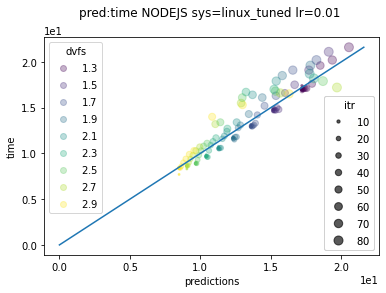

In [104]:
run_energy(df_comb, n_iter=10000, lr=0.01, mpred=['time'], msys=['linux_tuned'])

##8.6% errorfrom mean

In [ ]:
###test

In [139]:
def inference_time(d, n_iter, lr, workload, sys, print_freq=10):    
    #starts randomly
    max_time = torch.tensor(torch.Tensor(1,1).uniform_(1, 2), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 0), requires_grad=True)
    beta = torch.tensor(torch.Tensor(1,1).uniform_(0, 1), requires_grad=True)
    gamma = torch.tensor(torch.Tensor(1,1).uniform_(0, 1), requires_grad=True)
    delta = torch.tensor(torch.Tensor(1,1).uniform_(2, 3), requires_grad=True)
    
    ninterrupts = d[:,4]
    itr = d[:,1]
    dvfs = d[:,2]
    time = d[:,3]
    msgsize = d[:,5]
        
    criterion = nn.MSELoss()
    optimizer_time = optim.Adam([max_time, alpha, gamma, delta], lr=lr)

    for i in range(n_iter):        
        t_busy = (torch.exp(max_time) / dvfs**(1+alpha)) ## dvfs impact on processing
        
        #pred_time = itr_suppress*itr + t_busy
        #pred_time = ((2*((itr*itr_suppress)**beta))/(10**6)) + (gamma*(2*((msgsize*8)/(10**10)))) + (2*t_busy)
        #pred_time = (gamma*itr*itr_suppress)*(dvfs**beta)
        #pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy)                
        
        #pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))
        beta = gamma*dvfs+delta
        pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))
        
        #pred_time = A(itr)**beta*(dvfs**gamma)
        #pred_time = 2*itr**(alpha*dvfs)
        
        #import pdb
        #pdb.set_trace()
        
        #loss_time = criterion(pred_time/time, torch.ones((1,pred_time.shape[1])).double())
        loss_time = criterion(pred_time, time)
        
        if i % 1000 == 0:
            print(f'MSE_loss_time={loss_time.item()} loss_time={round(math.sqrt(loss_time.item())*10**6, 5)} us '
                 + f'max_time={max_time.item()} alpha={alpha.item()} gamma={gamma.item()} delta={delta.item()}')
            
        optimizer_time.zero_grad()
        loss_time.backward()
        optimizer_time.step()
    return pred_time

def inference_energy(d, n_iter, lr, workload, sys, print_freq=10):
    #starts randomly
    #max_time = torch.tensor(torch.Tensor(1,1).uniform_(-5, 5), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    #gamma = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    #delta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    
    ninterrupts = d[:,4]
    energy = (d[:,0]/ninterrupts) #(d[:,0]/ninterrupts).log() ## joules/num_interrupts
    itr = d[:,1]
    dvfs = d[:,2]
    time = d[:,3]
    msgsize = d[:,5]
        
    criterion = nn.MSELoss()
    optimizer_energy = optim.Adam([alpha, beta], lr=lr)
            
    for i in range(n_iter):
        #p_busy = (p_q*dvfs**(2+beta))
        #t_busy_energy = (max_time / dvfs**(1+beta))
        #t_q_energy = itr#(fixed_itr_suppress*itr)
        #t_q_energy = (interarrival_time - (fixed_itr_suppress*itr) - t_busy_energy)
        
        #pred_energy = (p_q * t_q_energy) + (p_busy * t_busy_energy)
        #pred_energy = AA*(fixed_itr_suppress*itr)**gamma + BB*dvfs**beta
        #loss_energy = criterion(pred_energy/energy, torch.ones((1,pred_energy.shape[1])).double())
        #pred_energy =  ((fixed_itr_suppress*itr*p_q)*((20*(10**6))/(fixed_itr_suppress*itr))) + (dvfs*beta)
        #pred_energy = ((alpha*(itr**gamma))*(delta*(dvfs**beta))) #+ (AA*(dvfs**beta))
        
        pred_energy = (alpha*itr*((msgsize*8)/(10**10)))+(dvfs*beta)
        #pred_energy = alpha*(itr+dvfs)
        #pred_energy = alpha+np.log(itr)+np.log(dvfs)
        
        #pred_energy = (gamma*(fixed_itr_suppress*itr))*(dvfs**beta) #+ (AA*(dvfs**beta))        
        #pred_energy = 2*(gamma+(np.log(itr)))+(2*(beta*np.log(dvfs)))
        
        loss_energy = criterion(pred_energy, energy)

        if i % 1000 == 0:
            print(f'MSE_loss_energy={loss_energy.item()} alpha={alpha.item()} beta={beta.item()}')
            
        optimizer_energy.zero_grad()
        loss_energy.backward(retain_graph=True)
        optimizer_energy.step()
    return pred_energy

def run(df_comb, n_iter=2000, lr=1, rmsg=64, msys=['ebbrt_tuned'], mpred=['energy', 'time']):       
    for sys in msys:
        df = df_comb[(df_comb['sys']==sys)].copy()
        #df = df[['joules','itr', 'dvfs', 'QPS', 'read_99th', 'num_interrupts']]
        print(df['itr'].unique())
        df = df[['joules', 'itr', 'dvfs', 'time', 'num_interrupts', 'msg']]
        
        tnum = df.shape[0]
        d = df.values
        d = torch.tensor(d)
        print('SYS', sys)
        
        #pred_energy, max_time, alpha, beta, p_detect, p_q = inference_energy(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        #pred_energy, pred_time = inference(d, n_iter, lr, 'netpipe', sys, print_freq=1000)
        for pred_name in mpred:
            if pred_name == 'energy':
                pred_energy = inference_energy(d, n_iter, lr, 'netpipe', sys, print_freq=1000)
                pred = pred_energy
                #yvalue = (d[:,0]/d[:,4]).log()
                yvalue = d[:,0]/d[:,4]
                #yvalue = d[:,0]
            else:
                pred_time = inference_time(d, n_iter, lr, 'netpipe', sys, print_freq=1000)
                pred = pred_time
                yvalue = d[:,3]

            fig, ax = plt.subplots()
            plt.title(f'pred:{pred_name} mcd sys={sys} lr={lr} \n MSG={rmsg}')
            #plt.title(f'pred:{pred_name} mcd sys={sys} lr={lr} tail={rtail} \n QPS={rqps} max_time={round(max_time,2)} \n alpha={round(alpha,2)} beta={round(beta.item(),2)} \n p_detect={round(p_detect.item(),2)}')
            plt.xlabel(u"predictions")
            plt.ylabel(f'{pred_name}')
            print('yvalue', yvalue.shape)
            
            
            #if pred_name == 'time':
            tmax = yvalue.max().item()
            plt.plot(np.linspace(0, tmax, 10), np.linspace(0, tmax, 10))
            
            scatter = ax.scatter(pred.detach().numpy(), yvalue, marker = 'o', 
                                 s = d[:,1], c = d[:,2], alpha=0.3)
            #scatter = ax.scatter(pred.detach().numpy(), yvalue, marker = 'o', alpha=0.3)
            plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
                        
            legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="dvfs")
            ax.add_artist(legend1)
            handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
            legend2 = plt.legend(handles, labels, loc="lower right", title="itr")
            ax.add_artist(legend2)

[ 2  4  6  8 12 16 20 24 28 32 36 40 50 60 70 80  0]
SYS linux_tuned
MSE_loss_time=22.17882687873267 loss_time=4709440.1874 us max_time=1.8131587505340576 alpha=-0.5364206433296204 gamma=0.31824231147766113 delta=2.3066892623901367


<ipython-input-129-a4efd0ac483b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(1, 2), requires_grad=True)
<ipython-input-129-a4efd0ac483b>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 0), requires_grad=True)
<ipython-input-129-a4efd0ac483b>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(0, 1), requires_grad=True)
<ipython-input-129-a4efd0ac483b>:6: UserWarning: To copy construct fro

MSE_loss_time=1.035170186285164 loss_time=1017433.13603 us max_time=2.328415870666504 alpha=-0.179485023021698 gamma=0.056357771158218384 delta=3.358389139175415
yvalue torch.Size([147])


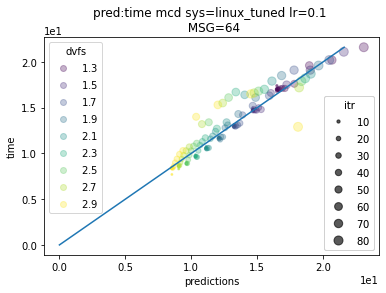

In [133]:
run(df_comb, n_iter=2000, lr=0.1, mpred=['time'], msys=['linux_tuned'])


[ 0  2  4  6  8 12 16 20 24 28 32 36 40 80 50 60 70]
SYS ebbrt_tuned
MSE_loss_time=9.679488415016243 loss_time=3111187.62131 us max_time=1.5235276222229004 alpha=-0.5037246346473694 gamma=0.5070372223854065 delta=2.2511630058288574


<ipython-input-139-30f25d44f84f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(1, 2), requires_grad=True)
<ipython-input-139-30f25d44f84f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 0), requires_grad=True)
<ipython-input-139-30f25d44f84f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(0, 1), requires_grad=True)
<ipython-input-139-30f25d44f84f>:6: UserWarning: To copy construct fro

MSE_loss_time=2.854975601040078 loss_time=1689667.30484 us max_time=1.507089614868164 alpha=-0.9582613706588745 gamma=0.2201293259859085 delta=2.9038984775543213
MSE_loss_time=2.85497560103439 loss_time=1689667.30484 us max_time=1.507089376449585 alpha=-0.9582617282867432 gamma=0.22012904286384583 delta=2.9038991928100586
MSE_loss_time=2.854975601031157 loss_time=1689667.30484 us max_time=1.5070887804031372 alpha=-0.9582623839378357 gamma=0.22012877464294434 delta=2.903899908065796
MSE_loss_time=2.8549756011879626 loss_time=1689667.30488 us max_time=1.5070887804031372 alpha=-0.9582623839378357 gamma=0.22012904286384583 delta=2.903900623321533
MSE_loss_time=2.854975601031157 loss_time=1689667.30484 us max_time=1.5070887804031372 alpha=-0.9582623839378357 gamma=0.22012877464294434 delta=2.903899908065796
MSE_loss_time=2.8549756010310454 loss_time=1689667.30484 us max_time=1.5070886611938477 alpha=-0.9582625031471252 gamma=0.22012867033481598 delta=2.903900146484375
MSE_loss_time=2.854975

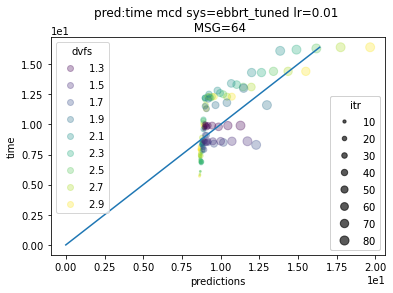

In [146]:
run(df_comb, n_iter=20000, lr=.01, mpred=['time'], msys=['ebbrt_tuned'])
